# Data analysis
This jupyter notebook will quanitfy and analyze the alpha generated by different actively managed mutual funds.  These mutual funds were chosen through a process that Richard will detail.

The goal of the project is two-fold.
- Determine the portion of returns for a given strategy that arises from exposure to various market or systematic risk factors
- Identify and quanityf the 'idiosyncratic alpha'

In [1]:
from tools import get_mutual_fund_data, get_bond_data, get_ff_data, get_index_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from data_tools import capm, ff_3, ff_5, reg_date_range, capm_index


Mutual Fund Data
Total mutual fund categories: 20
Total mutual funds: 20
Total number of rows: 8209
Columns: Index(['ticker', 'date', 'total_net_assets', 'total_returns',
       'net_asset_value'],
      dtype='object')

Bond Data
Columns: Index(['date', '30 Year Bond Return', '30 Year Bond Index Level',
       '20 Year Bond Return', '20 Year Bond Index Level',
       '10 Year Bond Return', '10 Year Bond Index Level', '7 Year Bond Return',
       '7 Year Bond Index Level', '5 Year Bond Return',
       '5 Year Bond Index Level', '2 Year Bond Return',
       '2 Year Bond Index Level', '1 Year Bond Return',
       '1 Year Bond Index Level', '90 Day Bond Return',
       '90 Day Bond Index Level', '30 Day Bond Return',
       '30 Day Bond Index Level', 'CPI Return', 'CPI Index Level'],
      dtype='object')

FF Data
          date  Mkt-RF   SMB   HML   RMW   CMA    RF
0   1963-07-31   -0.39 -0.41 -0.97  0.68 -1.18  0.27
1   1963-08-31    5.07 -0.80  1.80  0.36 -0.35  0.25
2   1963-09-30   

In [2]:
pd.set_option('display.max_rows', 10)

## Import data
First, we import data using the tools that Richard wrote.  This allows us to get mutual fund data in a dictionary.  In addition, we also want FF factors and CAPM factors to do some basic analysis

In [3]:
mf_dict = get_mutual_fund_data()
ff_df = get_ff_data()
bond_df = get_bond_data()
index_dict = get_index_data()


Mutual Fund Data
Total mutual fund categories: 20
Total mutual funds: 20
Total number of rows: 8209
Columns: Index(['ticker', 'date', 'total_net_assets', 'total_returns',
       'net_asset_value'],
      dtype='object')

FF Data
          date  Mkt-RF   SMB   HML   RMW   CMA    RF
0   1963-07-31   -0.39 -0.41 -0.97  0.68 -1.18  0.27
1   1963-08-31    5.07 -0.80  1.80  0.36 -0.35  0.25
2   1963-09-30   -1.57 -0.52  0.13 -0.71  0.29  0.27
3   1963-10-31    2.53 -1.39 -0.10  2.80 -2.01  0.29
4   1963-11-30   -0.85 -0.88  1.75 -0.51  2.24  0.27
..         ...     ...   ...   ...   ...   ...   ...
719 2023-06-30    6.46  1.34 -0.26  2.18 -1.62  0.40
720 2023-07-31    3.21  2.86  4.11 -0.57  0.57  0.45
721 2023-08-31   -2.39 -3.65 -1.06  3.43 -2.37  0.45
722 2023-09-30   -5.24 -1.80  1.52  1.86 -0.83  0.43
723 2023-10-31   -3.18 -4.03  0.19  2.47 -0.66  0.47

[724 rows x 7 columns]

Bond Data
Columns: Index(['date', '30 Year Bond Return', '30 Year Bond Index Level',
       '20 Year Bond Ret

## Data set
Let us first take a look at our data set to see what we are working with.  We are only working with actively managed funds and primarily those with the largest AUM.

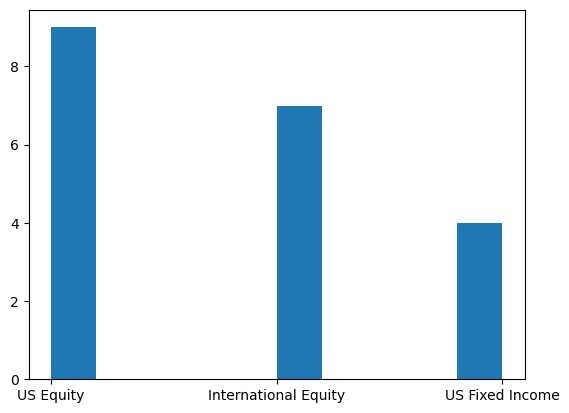

In [4]:
mf_types = list(mf_dict.keys())
mf_areas = [arr[1] for arr in mf_types]
plt.hist(mf_areas)
plt.show()

### Example df below

In [5]:
mf_dict[mf_types[10]]

,ticker,date,total_net_assets,total_returns,net_asset_value,nav_return
0,MDIDX,2004-10-31,15.300,0.026786,10.35,NaN
1,MDIDX,2004-11-30,41.200,0.065700,11.03,0.065700
2,MDIDX,2004-12-31,70.400,0.041922,11.41,0.034451
3,MDIDX,2005-01-31,94.600,-0.007888,11.32,-0.007888
4,MDIDX,2005-02-28,120.800,0.046820,11.85,0.046820
...,...,...,...,...,...,...
223,MDIDX,2023-05-31,3494.000,-0.035487,21.20,-0.035487
224,MDIDX,2023-06-30,3643.200,0.040566,22.06,0.040566
225,MDIDX,2023-07-31,3748.500,0.027199,22.66,0.027199
226,MDIDX,2023-08-31,3610.900,-0.033981,21.89,-0.033981


## US Equity
First, let us look at those actively managed US equity funds

### Get US Equity Data specifically

In [6]:
mf_types = list(mf_dict.keys())
us_eq_data = {k[2]: v for k, v in mf_dict.items() if 'US Equity' in k}
print(f'List of types of mutual funds being considered: {us_eq_data.keys()}')

List of types of mutual funds being considered: dict_keys(['US Large Value', 'US Large Blend', 'US Large Growth', 'US Mid Value', 'US Mid Blend', 'US Mid Growth', 'US Small Value', 'US Small Blend', 'US Small Growth'])


### CAPM
First, we run CAPM on each to find their beta and alpha.  This gives us a good baseline with which to work off of.  

Note that these are run allowing for herteroskedasticity.  They are also run for the full range of dates for now

#### CAPM on all listed companies
F-F data file

In [7]:
us_eq_alphas_c, us_eq_betas, us_eq_names = capm(us_eq_data, ff_df)

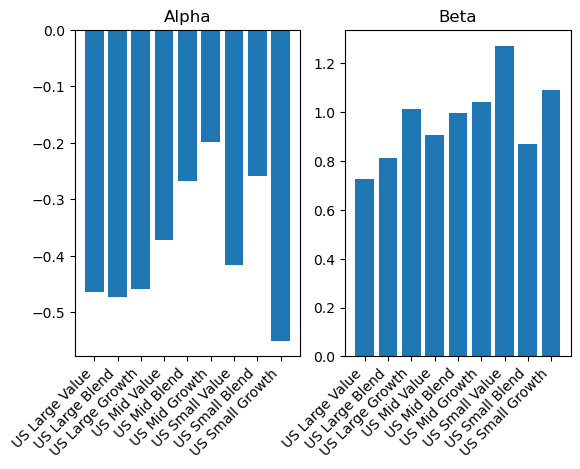

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(us_eq_names, us_eq_alphas_c)
ax2.bar(us_eq_names, us_eq_betas)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

#### CAPM on benchmark
Here instead we consider the market return as the benchmark index return

In [9]:
from data_tools import capm_index

In [10]:
us_index = {'US '+k[2]: v for k, v in index_dict.items() if 'US Equity' in k}
print(capm_index(us_eq_data['US Large Blend'], ff_df, us_index['US Large Blend'], '20200101', '20230101'))

{'const': -0.3226307976439557, 'beta': 0.8898744445153857}


### FF 3-Factor
This is the 3-factor model including SMB and HML

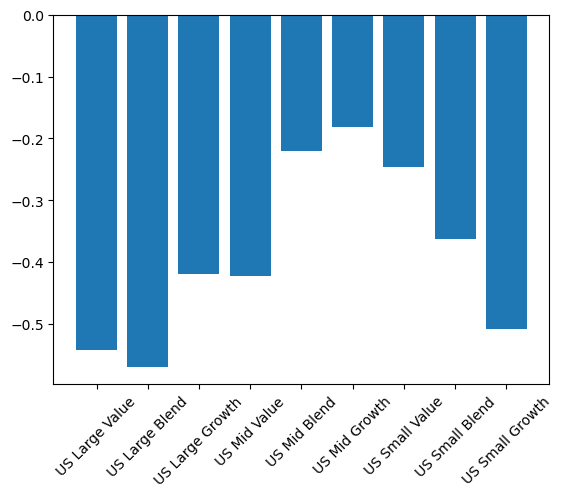

In [11]:
us_eq_alphas_3, us_eq_betas, us_eq_names, smbs, hmls = ff_3(us_eq_data, ff_df)
plt.bar(us_eq_names, us_eq_alphas_3)
plt.xticks(rotation=45)
plt.show()

### FF 5-Factor
This is the 3-factor model including SMB and HML.  RMW and CMA as well

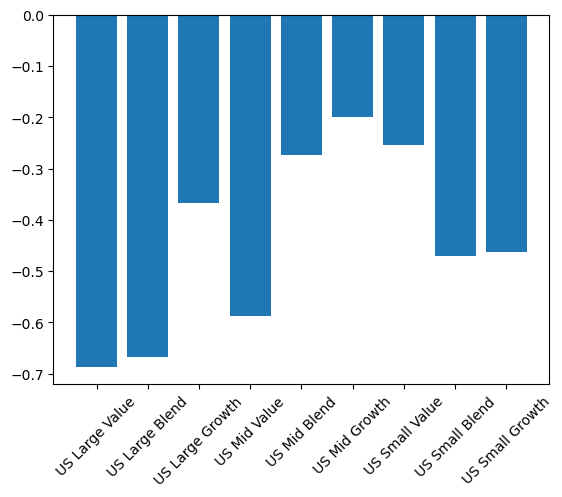

In [12]:
us_eq_alphas_5, us_eq_betas, us_eq_names, smbs, hmls, rmws, cmas = ff_5(us_eq_data, ff_df)
plt.bar(us_eq_names, us_eq_alphas_5)
plt.xticks(rotation=45)
plt.show()

### Combined bar graph of alpha from FF and CAPM

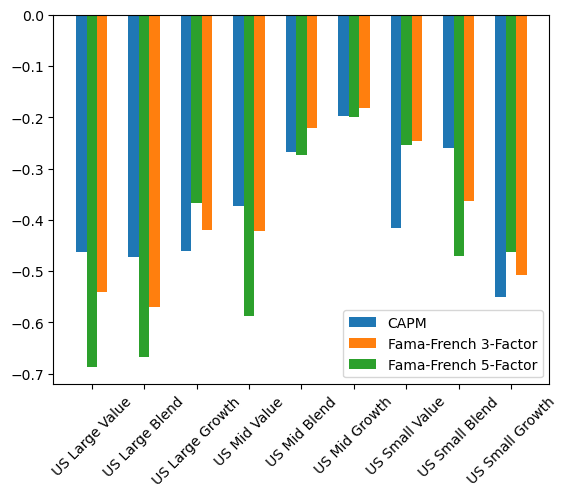

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx = np.arange(len(us_eq_names))


ax.bar(idx-0.2, us_eq_alphas_c, 0.2, label='CAPM')
ax.bar(idx+0.2, us_eq_alphas_3, 0.2, label='Fama-French 3-Factor')
ax.bar(idx, us_eq_alphas_5, 0.2, label='Fama-French 5-Factor')

ax.set_xticks(idx)
ax.set_xticklabels(us_eq_names, rotation=45)
ax.legend()
plt.show()

### Find results from date range
We can now look at the results from a data range more specifically.  The function below is an example of being able to do that

Probably looking at a date range after GFC and before Covid has the least randomness or impact of systematic risk.  Could do more looking into regions of low vol.

In [14]:
between_alpha = []
gfc_alpha = []
covid_alpha = []

for data in us_eq_data.values():
    between_alpha.append(reg_date_range(data, ff_df, ['Mkt-RF'], '20100101', '20200101')['const'])
    gfc_alpha.append(reg_date_range(data, ff_df, ['Mkt-RF'], '20071201', '20090601')['const'])
    covid_alpha.append(reg_date_range(data, ff_df, ['Mkt-RF'], '20200201', '20220101')['const'])

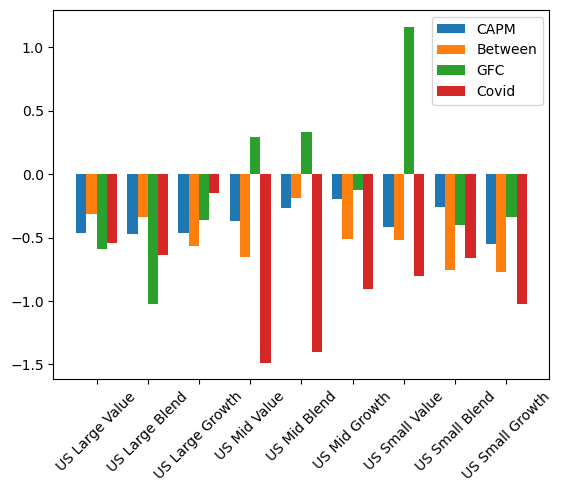

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

idx = np.arange(len(us_eq_names))


ax.bar(idx-0.3, us_eq_alphas_c, 0.2, label='CAPM')
ax.bar(idx-0.1, between_alpha, 0.2, label='Between')
ax.bar(idx+0.1, gfc_alpha, 0.2, label='GFC')
ax.bar(idx+0.3, covid_alpha, 0.2, label='Covid')

ax.set_xticks(idx)
ax.set_xticklabels(us_eq_names, rotation=45)
ax.legend()
plt.show()

### Correlations between MF and benchmark

In [16]:
from data_tools import corr_index

In [17]:
us_index = {'US '+k[2]: v for k, v in index_dict.items() if 'US Equity' in k}
print(corr_index(us_eq_data['US Large Blend'], us_index['US Large Blend'], '20200101', '20230101'))

0.9532989568194911


## International Equity
Next, we will look at international equity funds

### Get international Equity Data specifically

In [18]:
mf_types = list(mf_dict.keys())
int_data = {k[2]: v for k, v in mf_dict.items() if 'International Equity' in k}
print(f'List of types of mutual funds being considered: {int_data.keys()}')

List of types of mutual funds being considered: dict_keys(['Foreign Large Value', 'Foreign Large Blend', 'Foreign Large Growth', 'Foreign Small/Mid Value', 'Foreign Small/Mid Blend', 'Foreign Small/Mid Growth', 'Diversified Emerging Markets'])


### CAPM
First, we run CAPM on each to find their beta and alpha.  This gives us a good baseline with which to work off of.  

Note that these are run allowing for herteroskedasticity.  They are also run for the full range of dates for now

Also note that CAPM does not make a ton of sense here beacuse we are comparing international returns to the US markets, and how much it makes above that

In [19]:
int_alphas, int_betas, int_names = capm(int_data, ff_df)

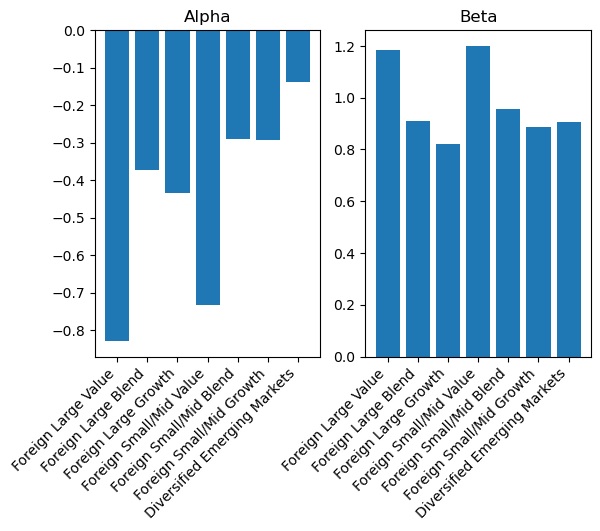

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.bar(int_names, int_alphas)
ax2.bar(int_names, int_betas)
fig.autofmt_xdate(rotation=45)
ax1.set_title('Alpha')
ax2.set_title('Beta')
plt.show()

## TODO
CAPM w/ benchmark index 

CAPM and FF on different date ranges (look at whether alpha specifically lower during Covid and GFC) (Limit range to between GFC and Covid)

Correlation to benchmark

Identify specifically positive alpha mutual funds, or those which have higher than average

correlation v alpha